# Figure 13: Contrast Curve vs Contrast Grid

This code is used to create **Figure 13** in the **Apples with Apples** paper [(Bonse et al. 2023)](../../05_citation.rst). The compares the results of a thresholded contrast grid with the analytical contrast curve. 

**For more information on how to calculate contrast grids with applefy click** [here](../../02_user_documentation/02_contrast_grid.ipynb).

**For more information on how to calculate contrast curves with applefy click** [here](../../02_user_documentation/01_contrast_curves.ipynb).

## Imports

In [1]:
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast
from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma

from applefy.utils.file_handling import load_adi_data, read_apples_with_apples_root
from applefy.utils.positions import center_subpixel
from applefy.utils import flux_ratio2mag, mag2flux_ratio

## Data Loading

Figure 13 runs several fake planet experiments on the unstacked NACO data (see details in the paper). In order to run the code **make sure to download the data from Zenodo and [read the instructions](../02_paper_data.md) on how to setup the files**.

In [2]:
experiment_root = read_apples_with_apples_root()

Data in the APPLES_ROOT_DIR found. Location: /home/ipa/quanz/user_accounts/mbonse/2021_Metrics/70_results/apples_root_dir


The HR (High Temporal Resolution) data is the unstacked NACO data. Calculations with this data can be **computationally intensive**. You can also run the code with the LR (Low Temporal Resolution) data to save time.

In [3]:
# 30_data/betapic_naco_lp_LR
dataset_file = experiment_root / Path("30_data/betapic_naco_lp_HR.hdf5")
science_data_key = "science_no_planet"
psf_template_key = "psf_template"
parang_key = "header_science_no_planet/PARANG"

dit_psf_template = 0.02019
dit_science = 0.2
fwhm = 4.2  # estimeated with Pynpoint in advance

We load the unstacked NACO data. In order to save computation time we reduce the resolution of the science sequence by cutting around the central star.

In [4]:
# we need the psf template for contrast calculation
science_data, angles, raw_psf_template_data = load_adi_data(
    dataset_file,
    data_tag=science_data_key,
    psf_template_tag=psf_template_key,
    para_tag=parang_key)

psf_template = raw_psf_template_data[82:-82, 82:-82]
science_data = science_data[:, 55:-55, 55:-55]

## Compute Contrast Curve and Grid

We use the class [Contrast](../../03_package/detections.rst#applefy.detections.contrast.Contrast) of applefy to calculate the contrast curves and grids. We can use the same instance for both calculations. The contrast curve will be based on the smallest flux ratio defined in the next step.

In [5]:
checkpoint_dir = experiment_root / Path("70_results/detection_limits/contrast_grid_lr")

contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    checkpoint_dir=checkpoint_dir)

### Step 1: Design fake planet experiments

In the first step we **choose** at which **separations** and for which **planet brightness** we want to insert fake planets. Compared to the example shown in the [user documentation](../../02_user_documentation/01_contrast_curves.ipynb) we run much more fake planet experiments in order to **increase the resolution** of the contrast grid. This is computational expensive on the unstacked data!

In [6]:
# fake planet brightness
flux_ratios_mag = np.linspace(5, 15, 21)
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: [ 5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5
 12.  12.5 13.  13.5 14.  14.5 15. ]
Planet-to-star flux ratio: [1.00000000e-02 6.30957344e-03 3.98107171e-03 2.51188643e-03
 1.58489319e-03 1.00000000e-03 6.30957344e-04 3.98107171e-04
 2.51188643e-04 1.58489319e-04 1.00000000e-04 6.30957344e-05
 3.98107171e-05 2.51188643e-05 1.58489319e-05 1.00000000e-05
 6.30957344e-06 3.98107171e-06 2.51188643e-06 1.58489319e-06
 1.00000000e-06]


By default, separations are selected in steps of 1 FWHM from the central star to the edge of the image. **We want twice the resolution for this plot**. The separations have to be given in pixel values.

In [7]:
# We want the double resolution as in the tutorial example
center = center_subpixel(science_data[0])
separations = np.arange(2.1, center[0], fwhm/2)[1:]
separations

array([ 4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. , 23.1, 25.2,
       27.3, 29.4, 31.5, 33.6, 35.7])

For each cell in the contrast grid we calculate *num_fake_planets* (between min=1 and max=6) planet residuals.

In [8]:
num_fake_planets = 6

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    separations=separations,
    overwrite=True)

Overwriting existing config files.


### Step 2: Run fake planet experiments

In the second step we **insert fake planetes** as chosen in the first step. For each planet we **run a full-frame PCA** to obtain a residual image. We use the [PynPoint](https://pynpoint.readthedocs.io/en/latest/) [wrappers](../../03_package/wrappers.rst) of applefy.

In [9]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

We compute the results for 5, 10, 20, 30 and 50 PCA components. For the plot later only two of the results is used.

In [10]:
components = [5, 10, 20, 30, 50]

**Make sure to choose a scratch folder which has a high bandwidth!**

In [11]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=Path("/scratch/mbonse/applefy_scratch2/"),
    num_cpus_pynpoint=1)

If the results are available from previous calculations the following step will just restore the residuals.

In [12]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=32)

Running fake planet experiments...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2017/2017 [00:13<00:00, 145.02it/s]


[DONE]


### Step 3: Pick the AperturePhotometryMode

Since we are close to the star in the speckle dominated regime we use spaced pixel instead of apertures to measure the pixel and noise photometry.

In [13]:
photometry_mode_planet = AperturePhotometryMode("FS", search_area=0.5)
photometry_mode_noise = AperturePhotometryMode("P")

In [14]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

### Step 4: Compute contrast curves

Next, we calculate the contrast curves using a [t-test](../../03_package/statistics.rst#applefy.statistics.parametric.TTest). In contrast to the example shown in the [user documentation](../../02_user_documentation/01_contrast_curves.ipynb) we only compute the contrast curve for 10 and 50 PCA components. The member *contrast_results* of the class [Contrast](../../03_package/detections.rst#applefy.detections.contrast.Contrast) contains a *dict* of [ContrastResults](../../03_package/detections.rst#applefy.detections.contrast.ContrastResult). These can be used to individually calculate the contrast curves of different algorithm setups.

In [15]:
contrast_result1 = contrast_instance.contrast_results["PCA (010 components)"]
contrast_result2 = contrast_instance.contrast_results["PCA (050 components)"]

Create the t-test.

In [16]:
ttest_statistic = TTest()

In [17]:
median_contrast_1, contrast_error_1 = \
    contrast_result1.compute_analytic_contrast_curve(
        confidence_level_fpf=gaussian_sigma_2_fpf(5),
        statistical_test=ttest_statistic,
        num_rot_iter=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:27<00:00,  9.23s/it]


In [18]:
median_contrast_2, contrast_error_2 = \
    contrast_result2.compute_analytic_contrast_curve(
        confidence_level_fpf=gaussian_sigma_2_fpf(5),
        statistical_test=ttest_statistic,
        num_rot_iter=360)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [02:29<00:00,  9.33s/it]


### Step 5: Compute the Contrast grids

The same for the contrast grids...

In [19]:
contrast_grid1, contrast_grid_curve1 = contrast_result1.compute_contrast_grid(
    statistical_test=ttest_statistic,
    num_cores=20,
    num_rot_iter=20,
    safety_margin=1.0,
    confidence_level_fpf=gaussian_sigma_2_fpf(5))

Computing contrast grid with multiprocessing:
................................................................................................................................................................................................................................................................................................................................................[DONE]


In [20]:
contrast_grid2, contrast_grid_curve2 = contrast_result2.compute_contrast_grid(
    statistical_test=ttest_statistic,
    num_cores=20,
    num_rot_iter=20,
    safety_margin=1.0,
    confidence_level_fpf=gaussian_sigma_2_fpf(5))

Computing contrast grid with multiprocessing:
................................................................................................................................................................................................................................................................................................................................................[DONE]


## Create the Plot

Define the colors we use.

In [21]:
color_palette = [sns.color_palette("colorblind")[1],
                 sns.color_palette("colorblind")[8]]

Convert some units.

In [22]:
separations = contrast_grid_curve2.index / fwhm

A small helper function to plot one contrast curve.

In [23]:
def plot_contrast_curve(separations_in,
                        median_contrast,
                        contrast_error,
                        label, 
                        axis):
    axis.plot(separations_in, 
              flux_ratio2mag(median_contrast), 
              label=label,
              lw=3)
    
    if contrast_error is not None:
        axis.fill_between(
            separations_in,
            flux_ratio2mag(median_contrast + contrast_error * 2), 
            flux_ratio2mag(median_contrast - contrast_error * 2),
            alpha=0.5)

Create the final figure.

/home/ipa/quanz/user_accounts/mbonse/2021_Metrics/50_code/applefy/applefy/utils/photometry.py:31: RuntimeWarning: invalid value encountered in log10
  return -np.log10(flux_ratios) * 2.5


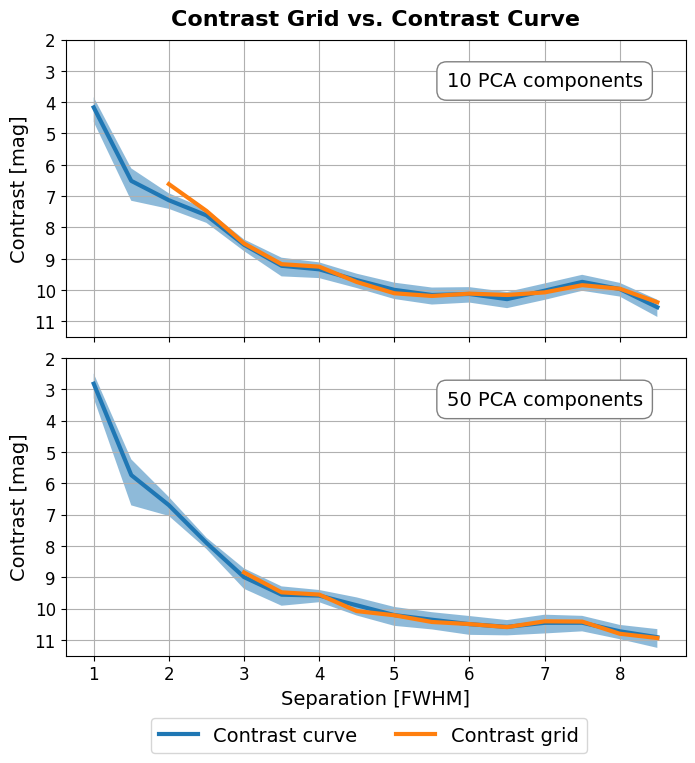

In [27]:
# 1. Create Plot Layout ------------------------------------------
fig = plt.figure(constrained_layout=False, figsize=(8, 8))
gs0 = fig.add_gridspec(2, 1)
gs0.update(hspace=0.07, wspace=0.09)

axis_pca_10 = fig.add_subplot(gs0[0])
axis_pca_50 = fig.add_subplot(gs0[1])

# 2. Plot the first comparison -----------------------------------
plot_contrast_curve(
    separations,
    median_contrast_1.values.flatten(), 
    contrast_error_1.values.flatten(), 
    "Contrast curve", axis_pca_10)

plot_contrast_curve(
    separations, 
    contrast_grid_curve1.values.flatten(),
    None, 
    "Contrast grid", axis_pca_10)

axis_pca_10.set_ylim(11.5, 2.5)
axis_pca_10.grid()
plt.setp(axis_pca_10.get_xticklabels(), visible=False)

axis_pca_10.text(
    7, 3.5, r"10 PCA components",
    ha="center", fontsize=14, #fontweight="bold",
    bbox=dict(facecolor='white',
              edgecolor='grey', 
              boxstyle='round,pad=0.5'))

# 3. Plot the first comparison at 50 pca  ------------------------
plot_contrast_curve(
    separations,
    median_contrast_2.values.flatten(),
    contrast_error_2.values.flatten(), 
    "Contrast Curve", axis_pca_50)

plot_contrast_curve(
    separations,
    contrast_grid_curve2.values.flatten(),
    None, 
    "Contrast Grid", axis_pca_50)

axis_pca_50.set_ylim(11.5, 2.5)
axis_pca_50.grid()

axis_pca_50.text(
    7, 3.5, r"50 PCA components",
    ha="center", fontsize=14, #fontweight="bold",
    bbox=dict(facecolor='white', 
              edgecolor='grey', 
              boxstyle='round,pad=0.5'))

# 4. Labels  ----------------------------------------------------
axis_pca_50.set_xlabel(r"Separation [FWHM]", size=14)
axis_pca_50.set_ylabel(r"Contrast [mag]", size=14)
axis_pca_10.set_ylabel(r"Contrast [mag]", size=14)
axis_pca_10.set_yticks(np.arange(2, 12, 1))
axis_pca_50.set_yticks(np.arange(2, 12, 1))
axis_pca_10.tick_params(axis='both',
                        which='major', 
                        labelsize=12)
axis_pca_50.tick_params(axis='both',
                        which='major', 
                        labelsize=12)
axis_pca_10.set_title(
    "Contrast Grid vs. Contrast Curve",
    fontsize=16, fontweight="bold", y=1.02)

# Legend
handles, labels = axis_pca_10.get_legend_handles_labels()
leg1 = fig.legend(handles, labels, 
                  bbox_to_anchor=(0.22, -0.024),
                  loc='lower left', ncol=2, fontsize=14)
plt.setp(leg1.get_title(),fontsize=14)


fig.patch.set_facecolor('white')
plt.savefig("./13_Contrast_grid_vs_curve.pdf", 
            bbox_extra_artists=(leg1,), 
            bbox_inches='tight')

Note: The warning is cause by np.inf values in the contrast curve derived from the grid.